# Workshop: In-Context Learning (ICL)
This notebook contains a tutorial on how to apply in-context learning to text classification task and named entity recognition (ner) task.

In [2]:
# make sure there's GPU on this instance
!nvidia-smi

Sat Nov 11 13:10:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8              14W /  20W |    949MiB /  6144MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Dependencies
Default Google Colab doesn't provides these following packages:

In [3]:
!pip install -q transformers datasets accelerate bitsandbytes seqeval evaluate

Apply seed to make sure that results are deterministic and reproducable.

If we don't run `seed_everything`, running this code two times will get different results.

In [4]:
import os
import random

import numpy as np
import torch


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download Model
Before we start with anything, let's download the model first! Note that we're using `pythainlp/wangchanglm-7.5B-sft-enth-sharded` (aka. [WangchanGLM](https://huggingface.co/pythainlp/wangchanglm-7.5B-sft-enth)) and it tooks around 20 minutes to download! (That's 1/3 of our workshop time!)

In [5]:
from typing import Tuple

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)

# downloading the model took around 20 minutes or so!

# model name
# you can try experiment with different model
# you can use local path to your model as well
# (local model needs to be in HF Format!)

# need to use sharded model because of colab limited memory availability
model_name = 'pythainlp/wangchanglm-7.5B-sft-enth-sharded'


def initialize_model(model_name_or_path: str) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        return_dict=True,
        load_in_8bit=True,  # we inference in 8bit for fast inference
        device_map="auto",  # auto select device: GPU
        torch_dtype=torch.float16,  # use float16
        offload_folder="./",  # specify offload folder
        low_cpu_mem_usage=True  # use_cpu_mem
    )

    # freeze all model weights
    for param in model.parameters():
            param.requires_grad = False

    # eval mode
    model.eval()
    print("Model vocab size = ", model.config.vocab_size)

    # load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("Tokenizer size = ", len(tokenizer))

    tokenizer.padding_side = "left"  # pad token to the left, since CLM is predicting text to the right
    tokenizer.pad_token = tokenizer.eos_token  # CLM use </s> stop token as pad

    # make sure tokenizer and model vocab size match
    assert model.config.vocab_size == len(tokenizer)
    return model, tokenizer

In [6]:
model, tokenizer = initialize_model(model_name)

(…)ft-enth-sharded/resolve/main/config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

C:\Users\tewwa\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tewwa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(…)esolve/main/pytorch_model.bin.index.json:   0%|          | 0.00/40.9k [00:00<?, ?B/s]

pytorch_model-00002-of-00099.bin:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

pytorch_model-00003-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00004-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00005-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00006-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00007-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00008-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00009-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00010-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00011-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00012-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00013-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00014-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00015-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00016-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00017-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00018-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00019-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00020-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00021-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00022-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00023-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00024-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00025-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00026-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00027-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00028-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00029-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00030-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00031-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00032-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00033-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00034-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00035-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00036-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00037-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00038-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00039-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00040-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00041-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00042-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00043-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00044-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00045-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00046-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00047-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00048-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00049-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00050-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00051-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00052-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00053-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00054-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00055-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00056-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00057-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00058-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00059-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00060-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00061-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00062-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00063-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00064-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00065-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00066-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00067-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00068-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00069-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00070-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00071-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00072-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00073-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00074-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00075-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00076-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00077-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00078-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00079-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00080-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00081-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00082-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00083-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00084-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00085-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00086-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00087-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00088-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00089-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00090-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00091-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00092-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00093-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00094-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00095-of-00099.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

pytorch_model-00096-of-00099.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

pytorch_model-00097-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00098-of-00099.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

pytorch_model-00099-of-00099.bin:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

C:\Users\tewwa\anaconda3\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


ValueError: XGLMForCausalLM does not support `device_map='auto'` yet.

# Text Classification: In-Context Learning

given examples for LLMs, the models need to answer the setiment of the input text

## Import Libraries
Import necessary libraries to load and preprocess the model

In [7]:
import math
import os
import random
from typing import Tuple, List

import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from tqdm.auto import tqdm

In [8]:
assert device == "cuda", \
    f"You're not using a GPU runtime type! Please configure runtime type by:\nRuntime>Change runtime type>Hardward Accelerator = T4 GPU"

AssertionError: You're not using a GPU runtime type! Please configure runtime type by:
Runtime>Change runtime type>Hardward Accelerator = T4 GPU

## Prepare and Preprocess Dataset
For this workshop, we'll use [`wisesight_sentiment`](https://huggingface.co/datasets/wisesight_sentiment), a sentiment analysis provided by [Wisesight](https://wisesight.com/).

The dataset contains the following label map:

`Labels: {"pos": 0, "neu": 1, "neg": 2, "q": 3}`

The text from this dataset was scraped from social media (e.g. Facebook, twitter, etc.) between 2016 and 2019.

In [ ]:
# load dataset from huggingface
dataset = load_dataset("wisesight_sentiment")

Generating train split:   0%|          | 0/21628 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2404 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2671 [00:00<?, ? examples/s]

In [ ]:
dataset["train"][0]

{'texts': 'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ',
 'category': 1}

### Formatting Labels
For this workshop, we'll guide you to the process of few-shot prompting. Few-shot prompting is one of the method to in-context learning (icl) where the context are several examples sampled from the training set.

However, there's several works that need to be done in order to craft our prompt. Since the label of the dataset is encoded as an integer format (e.g. 0, 1, 2, 3), we must preprocess those label into text string so that we can incorporate it into our prompt.

In [ ]:
wisesight_label_map = {
        0: "positive",
        1: "neutral",
        2: "negative",
        3: "question"
    }

def convert_label_id_to_text(example):
    example["label"] = wisesight_label_map[example["category"]]
    return example

# apply conversion from encoded int to string
dataset_processed = dataset.map(convert_label_id_to_text)

Map:   0%|          | 0/21628 [00:00<?, ? examples/s]

Map:   0%|          | 0/2404 [00:00<?, ? examples/s]

Map:   0%|          | 0/2671 [00:00<?, ? examples/s]

In [ ]:
dataset_processed["train"][0]

{'texts': 'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ',
 'category': 1,
 'label': 'neutral'}

## Crafting prompts
For the prompt, we'll use the following template:
```
จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้

ข้อความ: {texts}
ความรู้สึก: {label}

ข้อความ: {texts}
ความรู้สึก: {label}

ข้อความ: {texts}
ความรู้สึก: {label}

ข้อความ: {texts}
ความรู้สึก: {label}

ข้อความ: {actual_text}
ความรู้สึก:
```

**You can adjust your prompt, but note that the sequence length also grows!**

In [ ]:
pos_indices = [i for i, d in enumerate(dataset_processed["train"]) if d["label"] == "positive"]
neg_indices = [i for i, d in enumerate(dataset_processed["train"]) if d["label"] == "negative"]
neu_indices = [i for i, d in enumerate(dataset_processed["train"]) if d["label"] == "neutral"]
q_indices = [i for i, d in enumerate(dataset_processed["train"]) if d["label"] == "question"]

In [ ]:
def get_examples(dataset: Dataset, num_example_per_class: int = 1) -> Dataset:
    example_indices = [
        random.choice(pos_indices),
        random.choice(neg_indices),
        random.choice(neu_indices),
        random.choice(q_indices),
    ]
    return dataset["train"].select(example_indices)


def generate_prompt(text: str, dataset: Dataset, num_example_per_class: int) -> str:
    """Generate sentiment question prompt

    text: str - text to predict sentiment
    dataset: Dataset - HF Dataset to sample examples from
    num_example_per_class: int - specify how many example should we select from each class

    Return
    """
    examples = get_examples(dataset)

    prompt = "จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้\n\n"

    train_template = "ข้อความ: {texts}\n" "ความรู้สึก: {label}\n\n"
    test_template = "ข้อความ: {texts}\n" "ความรู้สึก: "

    for data_example in examples:
        prompt += train_template.format(**data_example)
    prompt += test_template.format(texts=text)
    return prompt

In [ ]:
text = dataset_processed["test"][0]["texts"]
prompt = generate_prompt(text, dataset_processed, num_example_per_class=1)
print(prompt)

จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้

ข้อความ: พ่อเป็นผู้ให้แสงสว่างแห่งปัญญา
ความรู้สึก: positive

ข้อความ: ม่ายไหวๆจิงๆ 5555 เอาแอคคอร์ดที่ยอดขายเน่าในเมกา มาจับทุบหน้าทุบตูด ทำไมฮอนด้าออกแบบล้าหลังไงไม่รุ้ ชอบฮอนด้ามาตลอดนะ แต่มันไม่สวยจิงๆอ่ะแล้วแต่คนชอบละกันคับ
ความรู้สึก: negative

ข้อความ: วาสนาคงไม่ถึง. ฉันจึงละเลียดความสุนทรีย์ ของหงส์ทองกับน้ำแข็งหลอด
ความรู้สึก: neutral

ข้อความ: พี่เตยยย มีใครน่าสนใจรับพรีเซต อินนิสฟรี วนว. ไหมTT น้องไม่รู้ซื้อกับใครดี
ความรู้สึก: question

ข้อความ: ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไม่ได้
ความรู้สึก: 


The prompt works perfectly! Now let's convert all test dataset into prompts!

In [ ]:
test_prompts, test_labels = [], []
for test_data in tqdm(dataset_processed["test"]):
    text = test_data["texts"]
    prompt = generate_prompt(text, dataset_processed, num_example_per_class=1)
    test_prompts.append(prompt)
    test_labels.append(test_data["label"].strip())

  0%|          | 0/2671 [00:00<?, ?it/s]

In [ ]:
print("PROMPT:")
print(test_prompts[0])

print()

print("LABEL:")
print(test_labels[0])

PROMPT:
จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้

ข้อความ: สเมอนอฟ สีน่ากิน55
ความรู้สึก: positive

ข้อความ: ไม่ค่อยชอบไลน์อาหารของฮอทพอทเท่าไรรรรรรงิ
ความรู้สึก: negative

ข้อความ: คงไม่น่าใช่พรุ่งนี้
ความรู้สึก: neutral

ข้อความ: นกแอร์กับแอร์เอเชียเที่ยวบินไประนองยกเลิกมั้ยค่ะ
ความรู้สึก: question

ข้อความ: ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไม่ได้
ความรู้สึก: 

LABEL:
negative


## Preparing Labels IDs
When we let Causal LM predict the next word, it returns the probability vector of a whole vocabulary. However, the word with highest probability could not be in our interest.

For example, if we `argmax` logits of next word obtained from the prompt and got `งง`. We wouldn't want to use it because we only care about the vocab if the label:
- `positive`
- `negative`
- `neutral`
- `question`

Thus, the probability of the next word should be **considered only the vocab index of those we interest**.

Let's prepare the vocab of our label that we're interested!

In [ ]:
# predefined the label text
labels = ["positive", "negative", "neutral", "question"]

In [ ]:
# we want label_ids to contains the vocab index
# of those labels defined above
label_ids = [] # init

# iterate over each label and tokenized label
for label, label_encoded in zip(
    labels, # label
    tokenizer.batch_encode_plus(labels)["input_ids"] # tokenized labels
):
    # label: str = one of ["positive", "negative", "neutral", "question"]
    # label_encoded: dict = encoded label text {"input_ids": [2, <label-vocab>]}
    label_id = label_encoded[-1] # the first index is a special token </s>, we ignore it
    label_str = tokenizer.convert_ids_to_tokens(label_id) # get vocab from the index
    print(label_str, label_id)
    label_ids.append(label_id) # add vocab id of the label to label_ids
label_ids = torch.tensor(label_ids, dtype=torch.long).to(device)
print(label_ids)

▁positive 17255
▁negative 24622
▁neutral 43835
▁question 5914
tensor([17255, 24622, 43835,  5914], device='cuda:0')


Looks great! We now got the token index of our label!
- `positive` is at index `17255`
- `negative` is at index `24622`
- `neutral` is at index `43835`
- `question` is at index `5914`

## Preparing ICL Inference Code

The idea of ICL is to leveraging the LLM next token prediction to predict the label using the prompt. In the above example, we've crafted the prompt and is expecting the model to fill the next token which is the sentiment of the give text.

The problem with this method is that the only signal we can utilize is the probability of the token that model emits. For example, let's investigate this prompt:
```
จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้

ข้อความ: พ่อเป็นผู้ให้แสงสว่างแห่งปัญญา
ความรู้สึก: positive

ข้อความ: ม่ายไหวๆจิงๆ 5555 เอาแอคคอร์ดที่ยอดขายเน่าในเมกา มาจับทุบหน้าทุบตูด ทำไมฮอนด้าออกแบบล้าหลังไงไม่รุ้ ชอบฮอนด้ามาตลอดนะ แต่มันไม่สวยจิงๆอ่ะแล้วแต่คนชอบละกันคับ
ความรู้สึก: negative

ข้อความ: วาสนาคงไม่ถึง. ฉันจึงละเลียดความสุนทรีย์ ของหงส์ทองกับน้ำแข็งหลอด
ความรู้สึก: neutral

ข้อความ: พี่เตยยย มีใครน่าสนใจรับพรีเซต อินนิสฟรี วนว. ไหมTT น้องไม่รู้ซื้อกับใครดี
ความรู้สึก: question

ข้อความ: ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไม่ได้
ความรู้สึก:
```

In the given prompt, the model needs to predict the next token, and we're expecting it to return one of the following choices: `positive`, `negative`, `question`, and `neutral`.

However, we know that the model has up to 256,008 vocabulary size. How can we ensure that the most likely token that the model predicts will be the one that we wanted?

To tackle this problem, we can scope the output of the next token prediction to the only tokens that we want. For exmaple, in the previous section, we get the token indices of the class label:

```
▁positive 17255
▁negative 24622
▁neutral 43835
▁question 5914
```

This means that instead of we choosing the vocab among all 256,008 vocab, we can prune all other vocab, but letting the model select only one of these 4 tokens!

Therefore, the steps for doing an ICL for text classification is as follows:

Given the `text` and `examples`, we want the LLM to predict the sentiment of `text` using the given `examples`:
- 1. Craft prompt using `text` and `examples`
- 2. Getting the possible word indices that the model can predict. The possible word indices are the token index that allows the model to predict the class name.
- 3. Let LLM predict the next token, getting the logits of the next time step token
- 4. Prune all vocab indices that we're not interested, keeping only indices we obtained in (2)
- 5. Select the most likely token from pruned logits. This way we can guarantee that the model can only predict the class name.

### Preparing for Batch Decoding

Since we're making a prediction in a batch (although we need a very small batch size since we're limited by GPU memory), we want to make sure that the tokenizer is padded to max length of each batch.

Let's define our `get_max_length` that return the max length of each batch!

In [ ]:
# get longest sequence length in the batch
def get_max_length(prompts: List[str]) -> int:
    max_length = -1
    for _prompt in prompts:
        tokenized_prompt = tokenizer(_prompt)
        seq_len = len(tokenized_prompt["input_ids"])
        # sanity check
        assert seq_len == sum(tokenized_prompt["attention_mask"])
        if seq_len > max_length:
            max_length = seq_len
    return max_length

# test get max length of the dataset
print(f"Max length: {get_max_length(test_prompts)}")

Max length: 854


Now let's define the function that allows loaded model to predict the next word from the prepared test prompt (in batch), and return the list of
1. Model completion from all vocab
2. Probability of each class, obtained from applying softmax from the logits of the interested vocab defined in `label_ids`

In [ ]:
def generate_output(prompts: List[str]):
    max_length = get_max_length(prompts)
    batch = tokenizer.batch_encode_plus(
        prompts,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True)

    # move batch tensor to GPU
    batch = batch.to(device)

    input_length = batch["input_ids"].shape[1]
    # sanity check
    assert input_length == max_length

    # forward model
    with torch.no_grad():
        output = model.generate(
            **batch,
            max_length=input_length+1,  # we only need to predict one additional word anyway
            output_hidden_states=True,
            output_scores=True,
            do_sample=False,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )

    encoded = output.sequences # get encoded output sequence
    decoded = tokenizer.batch_decode(encoded[:, input_length:]) # get only last text, List[str] with size of batch_size
    logits_all = output.scores[0] # get logits (batch_size, num_vocab)

    completions, probs = [], []
    assert len(logits_all) == len(decoded) # sanity check
    for _logit, _completion in zip(logits_all, decoded):
        # funfact: we can actually skip the softmax path since we're gonna argmax anyway
        # but we does this so that we want to see the class's probability
        output_probs = F.softmax(_logit[label_ids], dim=0) # label prob is a softmax of interested vocab index
        prediction = _logit.argmax(0) # get answer index

        completions.append(_completion)
        probs.append(output_probs)

    return completions, probs

Now with everything ready, let's predict the prompt!

In [ ]:
batch_size = 2

# init
results, probs = [None] * len(test_prompts), [None] * len(test_prompts)

# iterate over each batch
for i in tqdm(
    range(0, len(test_prompts), batch_size),  # get index with step of batch_size
    total=math.ceil(len(test_prompts) / batch_size) # fancy tqdm settings for progress bar
):
    # get the batch
    start_idx, end_idx = i, min(i + batch_size, len(test_prompts))
    batch = test_prompts[start_idx:end_idx]

    # predict batch
    pred_completions, pred_probs = generate_output(batch)

    # gather probability and completion results
    assert len(pred_completions) == len(pred_probs) # sanity check b4 zip
    for j, (_completion, _prob) in enumerate(zip(pred_completions, pred_probs)):
        item_idx = start_idx + j
        results[item_idx] = _completion.strip()
        probs[item_idx] = _prob

  0%|          | 0/1336 [00:00<?, ?it/s]

In [ ]:
# inspect prediction
idx = 2 # index  of test data

print("[PROMPT]")
print(test_prompts[idx])
print()

print("[MODEL COMPLETION]")
print(results[idx])
print()

print("[PREDICTION PROBABILITY]")
for i, (k, v) in enumerate(wisesight_label_map.items()):
    print(f"{v}> {probs[idx][k]*100:.4f}%")

print(f"\npredict> {wisesight_label_map[probs[idx].argmax().cpu().numpy().tolist()]}")

[PROMPT]
จงบอกความรู้สึกของข้อความจากตัวอย่างที่กำหนดให้

ข้อความ: จัยรัวๆๆๆๆๆๆๆๆๆ
ความรู้สึก: positive

ข้อความ: จ่ายเงินเล่นนะครับเน็ตไม่ได้ขอเล่นฟรี เน่ามา2วันละหมุนติ้วๆ
ความรู้สึก: negative

ข้อความ: ก้อนขอบพระคุณสำหรับข้อมุลนะคร้าบ
ความรู้สึก: neutral

ข้อความ: ช้อปของ mamonde ค่ะ ลองเช็คที่ Mamondethailand
ความรู้สึก: question

ข้อความ: การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเอส (รถไฟฟ้า) มันสำนึกมั้ย ก็ไม่อ่ะ 😕
ความรู้สึก: 

[MODEL COMPLETION]
งง

[PREDICTION PROBABILITY]
positive> 6.4883%
neutral> 27.0938%
negative> 55.1875%
question> 11.2109%

predict> negative


## Evaluate Few-shot Prompting
Now that we got the prediction of the ICL model, let's evaluate the model!

In [ ]:
icl_predictions = [
    wisesight_label_map[_prob.argmax().cpu().numpy().tolist()]
    for _prob in probs
]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, icl_predictions))

              precision    recall  f1-score   support

    negative       0.25      0.45      0.32       683
     neutral       0.44      0.25      0.32      1453
    positive       0.31      0.35      0.33       478
    question       0.06      0.07      0.06        57

    accuracy                           0.31      2671
   macro avg       0.26      0.28      0.26      2671
weighted avg       0.36      0.31      0.31      2671



Not so impressive right? There's a lot of room to improve to ICL! Good luck with your Hackathon!

# Named-Entity Recognition (NER): In-Context Learning

given examples for LLMs, the model predicts the corresponding tag from the sentence

In [ ]:
import os
import random
from dataclasses import dataclass, field
from functools import partial
from typing import Tuple, List, Dict, Any, Optional

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from datasets import load_dataset
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import TrainingArguments, Trainer
from transformers import (
    AutoModelForTokenClassification,
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    DataCollatorForTokenClassification
)

In [ ]:
seed_everything(42) # apply seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare Dataset
Download [thainer](https://huggingface.co/datasets/pythainlp/thainer-corpus-v2) corpus from Huggingface.

In [ ]:
# Prepare NER dataset
dataset = load_dataset("pythainlp/thainer-corpus-v2")
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3938 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1313 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1313 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['words', 'ner'],
        num_rows: 3938
    })
    validation: Dataset({
        features: ['words', 'ner'],
        num_rows: 1313
    })
    test: Dataset({
        features: ['words', 'ner'],
        num_rows: 1313
    })
})

In [ ]:
# Prepare NER classes
classes_list: List[str] = dataset["train"].features["ner"].feature._int2str
class_to_idx: Dict[str, int] = {class_name: idx for idx, class_name in enumerate(classes_list)}
idx_to_class: Dict[int, str] = {idx: class_name for class_name, idx in class_to_idx.items()}
print(f"Number of classes: {len(classes_list)}")
class_to_idx

Number of classes: 36


{'B-PERSON': 0,
 'I-PERSON': 1,
 'O': 2,
 'B-ORGANIZATION': 3,
 'B-LOCATION': 4,
 'I-ORGANIZATION': 5,
 'I-LOCATION': 6,
 'B-DATE': 7,
 'I-DATE': 8,
 'B-TIME': 9,
 'I-TIME': 10,
 'B-MONEY': 11,
 'I-MONEY': 12,
 'B-FACILITY': 13,
 'I-FACILITY': 14,
 'B-URL': 15,
 'I-URL': 16,
 'B-PERCENT': 17,
 'I-PERCENT': 18,
 'B-LEN': 19,
 'I-LEN': 20,
 'B-AGO': 21,
 'I-AGO': 22,
 'B-LAW': 23,
 'I-LAW': 24,
 'B-PHONE': 25,
 'I-PHONE': 26,
 'B-EMAIL': 27,
 'I-EMAIL': 28,
 'B-ZIP': 29,
 'B-TEMPERATURE': 30,
 'I-TEMPERATURE': 31,
 'B-DTAE': 32,
 'I-DTAE': 33,
 'B-DATA': 34,
 'I-DATA': 35}

Read more on explanation on how we prepare annotation [here](https://colab.research.google.com/drive/1CKuRrNbqpl6aR2GN-VvcgabxZv7GdHxn#scrollTo=Lq9eECJy7MgC)

In [ ]:
class Benchmark(object):

    def __init__(self) -> None:
        # define seqeval object loaded from HF's `evaluate` lib
        self.seqeval = evaluate.load("seqeval")

    def eval(
        self,
        predictions: List[List[int]],
        labels: List[List[int]],
    ) -> dict:
        """Run evaluation on predictions and labels, return
        a dictionary consists of Precision, Recall, F1, and accuracy
        of the span predicted
        """
        # convert encoded predictions to string
        true_predictions = [
            [classes_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        # convert encoded labels to string
        true_labels = [
            [classes_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # use seqeval to compute metrics
        results = self.seqeval.compute(predictions=true_predictions, references=true_labels)

        # return metrics dict
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
benchmark = Benchmark()

## Prepare In-Context Learning Model
Like previous example, we'll use the `wangchanglm` model for this workshop. We'll demonstrate how to apply in-context learning for token classification (NER) task.

In [ ]:
# instantiate model if haven't yet
if "model" not in locals() and "tokenizer" not in locals():
    model, tokenizer = initialize_model(model_name)

In [ ]:
model

XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 4096, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-31): 32 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=True)
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=True)
          (out_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear8bitLt(in_features=4096, out_features=16384, bias=True)
        (fc2): Linear8bitLt(in_features=16384, out_features=4096, bias=True)
        (final_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm(

## Preparing In-Context Learning Prompt
Like in previous ICL for text classification example, the model doesn't need to be trained at all, just prompt some question and let the LLM fill the answers. In order to let the Causal LM predicts the NER tags, we adopt the following prompt:

```
จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ: หนาว|ระลอก|ใหม่| |เกิด|น้ำค้างแข็ง|ยอด|ดอย|อินทนนท์
คำตอบ: O|O|O|O|O|O|B-LOCATION|I-LOCATION|I-LOCATION

ข้อความ: ที่|สิงคโปร์| |แอนดี้| |วิ|ลเลียมส์| |นักร้อง|รุ่น|อาวุโส|ชาว|อเมริกัน| |วัย| |76| |ปี| |ประกาศ|เลื่อน|คอนเสิร์ต|ที่|สิงคโปร์| |ญี่ปุ่น| |ไทย| |และ|ฮ่องกง| |ใน|เดือน|มี|.ค.| |ไป|เป็น|เดือน|ก.ค.|แทน| |เนื่องจาก|หวั่น|ว่า|มีอายุ|มาก|และ|สุขภาพ|ไม่ค่อย|ดี|อาจ|ติดเชื้อ|ไข้หวัด|นก| |พร้อมกันนี้| |รัฐบาล|สิงคโปร์|ยัง|สั่ง|ฆ่า|อีกา|เพราะ|เป็น|สัตว์|ที่|บิน|ย้ายถิ่น| |แม้ว่า|จะ|ยัง|ไม่|พบ|เชื้อ|ไข้หวัด|นก|ใน|อีกา
คำตอบ: O|B-LOCATION|O|B-PERSON|I-PERSON|I-PERSON|I-PERSON|O|O|O|O|O|O|O|O|O|B-AGO|I-AGO|I-AGO|O|O|O|O|O|B-LOCATION|O|B-LOCATION|O|B-LOCATION|O|O|B-LOCATION|O|O|O|B-DATE|I-DATE|O|O|O|O|B-DATE|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|B-ORGANIZATION|I-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O

ข้อความ: กรมสรรพากร| |แจง|การ|ส่ง|ข้อมูล|เบี้ยประกัน|สุขภาพ| |เพื่อ|ใช้|สิทธิ์|ลดหย่อน|ภาษี|ได้|ถึง|วันที่| |7| |มกราคม| |2562
คำตอบ:
```

The above is a few-shot ICL with a sample size of 2, without example, we'll get a zero-shot prompting with the following text prompt:
```
จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ: หนาว|ระลอก|ใหม่| |เกิด|น้ำค้างแข็ง|ยอด|ดอย|อินทนนท์
```

**Feels free to adjust your prompt in your work!**

In [ ]:
WORD_DELIMITER_TOKEN = "|"


def sample_examples(train_dataset: Dataset, num_example: int = 2) -> List[dict]:
    """Sample example from training data for few-shot prompting"""
    example_indices = random.choices(range(len(train_dataset)), k=num_example)
    return train_dataset.select(example_indices)


def get_input_prompt(words: List[str]) -> str:
    """Convert tokenized sentence in Thai, converted to prompt string"""
    return WORD_DELIMITER_TOKEN.join(words)


def get_labels_prompt(labels: List[str]) -> str:
    """Convert token label into prompt string"""
    return WORD_DELIMITER_TOKEN.join([idx_to_class[label] for label in labels])


def create_prompt(words: List[str], examples: Optional[List[dict]] = None) -> str:
    instruction = f"จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร\n\n"

    # add few-shot example if needed
    if examples is not None:
        for example_words, example_labels in zip(examples["words"], examples["ner"]):
            instruction += f"ข้อความ:{get_input_prompt(example_words)}\n"
            instruction += f"คำตอบ:{get_labels_prompt(example_labels)}\n\n"

    instruction += f"ข้อความ:{get_input_prompt(words)}\nคำตอบ:"
    return instruction

In [ ]:
# let's test our prompt!

idx = 12 # test index
num_example = 2 # number of few-shot samples

words = dataset["test"][idx]["words"] # get word from test set
labels = WORD_DELIMITER_TOKEN.join([classes_list[i] for i in dataset["test"][idx]["ner"]])
print(create_prompt(words, examples=sample_examples(dataset["train"], num_example=num_example)))

print()
print("LABEL>")
print(labels)

จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ:พล.ต.|สรรเสริญ| |แก้ว|กำเนิด| |โฆษก|ประจำ|สำนักนายกรัฐมนตรี| |เปิดเผย|ว่า|พล|.|อ.|ประยุทธ์| |จันทร์|โอชา| |นายกรัฐมนตรี|และ|หัวหน้า| |คสช.| |ชื่นชม|เกษตรกร|ที่|เข้าใจ|สถานการณ์|น้ำ|ของ|ประเทศ| |และ|ให้ความร่วมมือ| |ปรับเปลี่ยน|พฤติ|กรรมการ|ปลูก|พืช|ใน|หน้าแล้ง|จาก|ข้าวนาปรัง| |ไป|สู่|พืช|ใช้|น้ำ|น้อย|และ|การเลี้ยงปศุสัตว์|แทน
คำตอบ:B-PERSON|I-PERSON|I-PERSON|I-PERSON|I-PERSON|O|O|O|B-ORGANIZATION|O|O|O|B-PERSON|I-PERSON|I-PERSON|I-PERSON|I-PERSON|I-PERSON|I-PERSON|O|O|O|O|O|B-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O

ข้อความ:ศาลฎีกา|นักการเมือง| |พิพากษา| |ยึดทรัพย์| |เกษม| |นิ|มมล|รัตน์| | |อดีต| |ส.ส.|เชียงใหม่| |พรรคเพื่อไทย| |21| |ล้าน|บาท| |คดี|ร่ำรวยผิดปกติ
คำตอบ:B-ORGANIZATION|I-ORGANIZATION|O|O|O|O|O|B-PERSON|I-PERSON|I-PERSON|I-PERSON|I-PERSON|O|O|O|O|O|B-LOCATION|O|B-ORGANIZATION|O|B-MONEY|I-MONEY|I-MONEY|I-MONEY|O|O|O

ข้อความ:หลังจากที่| |พล|.|อ.|สุรยุทธ์| |จุ|ลา|นนท์| |องคมนต

## Prepare LLM Decoder for NER Task

Just like in ICL for text classification, in previous example we prepare the possible token label indices to constraint model prediction. For this task, we also does the same job.

However, the tricky thing about this NER classes is that instead of having a single token as a class label, now we have multiple tokens for each class. For example, `B-AGO` -> `[_B, -, AGO]`, `B-PERCENT` -> `[_B, -, PER, CENT]`, `B-PERSON` -> `[_B, PER, SON]`, etc.

This make ICL decoding increasingly difficult, but let's take a deep breath and solve this step-by-step.

In [ ]:
# get class label strings
ner_classes_wo_prefix = sorted(set([
    _cls.split("-")[-1]
    for _cls in classes_list
    if _cls != "O"
]))
ner_classes_wo_prefix

['AGO',
 'DATA',
 'DATE',
 'DTAE',
 'EMAIL',
 'FACILITY',
 'LAW',
 'LEN',
 'LOCATION',
 'MONEY',
 'ORGANIZATION',
 'PERCENT',
 'PERSON',
 'PHONE',
 'TEMPERATURE',
 'TIME',
 'URL',
 'ZIP']

In [ ]:
# get tokenized representation of each class name
ner_token_ids = dict()
for label_name in ner_classes_wo_prefix:
    # we add prefix | in front of the text to get rid of unnecessary
    # sentencepiece space token _
    # e.g.
    # by inserting | in front, the text becomes -> |TEMPERATURE instead of TEMPERATURE
    # after tokenizing the text,
    # without inserting, we got [_TEMP, ERA, TURE]
    # with | inserted, we got [_, |, TEM, PER, A, TURE]
    # notice that there's missing _ in front of TEMP
    # the _ was inserted to show that _TEMP was a start of the word
    # but we'll use this as a suffix to the B-TEMPERATURE or I-TEMPERATURE
    # we the TEMP didn't behave as a start of the word, so we need to apply
    # this hack
    tokenized_label = tokenizer("|" + label_name)["input_ids"][3:] # skip </s> pad token and special _, | token
    tokenized_label_str = tokenizer.convert_ids_to_tokens(tokenized_label)

    print(f"Class name `{label_name}` was tokenized into `{tokenized_label_str}` with index {tokenized_label}")
    ner_token_ids[label_name] = tokenized_label

special_token_ids = dict()
for special_token in [WORD_DELIMITER_TOKEN, "O", "B", "I", "-"]:
    tokenized_label = tokenizer("|" + special_token)["input_ids"][3:] # skip </s> pad token and special _, | token
    tokenized_label_str = tokenizer.convert_ids_to_tokens(tokenized_label)

    print(f"Special token `{special_token}` was tokenized into `{tokenized_label_str}` with index {tokenized_label}")
    special_token_ids[special_token] = tokenized_label

Class name `AGO` was tokenized into `['AGO']` with index [63837]
Class name `DATA` was tokenized into `['DATA']` with index [168721]
Class name `DATE` was tokenized into `['DATE']` with index [209477]
Class name `DTAE` was tokenized into `['DT', 'AE']` with index [28748, 16085]
Class name `EMAIL` was tokenized into `['E', 'MAIL']` with index [445, 86016]
Class name `FACILITY` was tokenized into `['FA', 'CIL', 'ITY']` with index [11371, 197618, 49022]
Class name `LAW` was tokenized into `['LAW']` with index [227220]
Class name `LEN` was tokenized into `['LEN']` with index [48420]
Class name `LOCATION` was tokenized into `['LOC', 'ATION']` with index [205616, 41699]
Class name `MONEY` was tokenized into `['MONEY']` with index [132546]
Class name `ORGANIZATION` was tokenized into `['ORG', 'ANI', 'Z', 'ATION']` with index [20394, 23576, 930, 41699]
Class name `PERCENT` was tokenized into `['PER', 'CENT']` with index [35112, 231856]
Class name `PERSON` was tokenized into `['PER', 'SON']` wi

In [ ]:
ner_token_ids

{'AGO': [63837],
 'DATA': [168721],
 'DATE': [209477],
 'DTAE': [28748, 16085],
 'EMAIL': [445, 86016],
 'FACILITY': [11371, 197618, 49022],
 'LAW': [227220],
 'LEN': [48420],
 'LOCATION': [205616, 41699],
 'MONEY': [132546],
 'ORGANIZATION': [20394, 23576, 930, 41699],
 'PERCENT': [35112, 231856],
 'PERSON': [35112, 25741],
 'PHONE': [24150, 21203],
 'TEMPERATURE': [112170, 35112, 198, 78363],
 'TIME': [155540],
 'URL': [34206],
 'ZIP': [930, 8597]}

In [ ]:
special_token_ids

{'|': [13445], 'O': [444], 'B': [426], 'I': [347], '-': [8]}

In [ ]:
words

['หลังจากที่',
 ' ',
 'พล',
 '.',
 'อ.',
 'สุรยุทธ์',
 ' ',
 'จุ',
 'ลา',
 'นนท์',
 ' ',
 'องคมนตรี',
 ' ',
 'และ',
 'อดีต',
 'นายกรัฐมนตรี',
 ' ',
 'ตอบ',
 'ข้อซักถาม',
 'ผู้สื่อข่าว',
 'ว่า',
 ' ',
 'หาก',
 ' ',
 'พ.ต.ท.',
 'ทักษิณ',
 ' ',
 'ชินวัตร',
 ' ',
 'อดีต',
 'นายกรัฐมนตรี',
 ' ',
 'โทรศัพท์',
 'มา',
 'คุย',
 'ด้วย',
 'ก็',
 'พร้อม',
 'จะ',
 'เป็น',
 'คนกลาง',
 'ช่วย',
 'ประสาน',
 'เจรจา',
 'เพื่อ',
 'ยุติ',
 'ความขัดแย้ง',
 'ทางการเมือง',
 ' ',
 'ต่อมา',
 'นาย',
 'นพดล',
 ' ',
 'ปัทมะ',
 ' ',
 'ที่ปรึกษา',
 'กฎหมาย',
 ' ',
 'พ.ต.ท.',
 'ทักษิณ',
 ' ',
 'ก็',
 'ออกมา',
 'ขานรับ',
 ' ',
 'โดย',
 'อ้างว่า',
 ' ',
 'พ.ต.ท.',
 'ทักษิณ',
 'พร้อม',
 'ที่จะ',
 'พูดคุย',
 'เพื่อให้',
 'บ้านเมือง',
 'เดินหน้า',
 'ต่อไป',
 'ได้',
 ' ',
 'แต่',
 'ต้อง',
 'คำนึงถึง',
 'เงื่อนไข',
 ' ',
 '3',
 ' ',
 'ข้อ',
 'คือ',
 ' ',
 '1',
 '.',
 ' ',
 'นำ',
 'รัฐธรรมนูญ',
 'ฉบับ',
 'ปี',
 ' ',
 '40',
 ' ',
 'กลับมา',
 'ใช้',
 ' ',
 '2',
 '.',
 ' ',
 'ยุบสภา',
 ' ',
 '3',
 '.',
 'ต้อง',
 'มี',
 'การเลือ

In [ ]:
prompt = create_prompt(words)
print(prompt)

จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ:หลังจากที่| |พล|.|อ.|สุรยุทธ์| |จุ|ลา|นนท์| |องคมนตรี| |และ|อดีต|นายกรัฐมนตรี| |ตอบ|ข้อซักถาม|ผู้สื่อข่าว|ว่า| |หาก| |พ.ต.ท.|ทักษิณ| |ชินวัตร| |อดีต|นายกรัฐมนตรี| |โทรศัพท์|มา|คุย|ด้วย|ก็|พร้อม|จะ|เป็น|คนกลาง|ช่วย|ประสาน|เจรจา|เพื่อ|ยุติ|ความขัดแย้ง|ทางการเมือง| |ต่อมา|นาย|นพดล| |ปัทมะ| |ที่ปรึกษา|กฎหมาย| |พ.ต.ท.|ทักษิณ| |ก็|ออกมา|ขานรับ| |โดย|อ้างว่า| |พ.ต.ท.|ทักษิณ|พร้อม|ที่จะ|พูดคุย|เพื่อให้|บ้านเมือง|เดินหน้า|ต่อไป|ได้| |แต่|ต้อง|คำนึงถึง|เงื่อนไข| |3| |ข้อ|คือ| |1|.| |นำ|รัฐธรรมนูญ|ฉบับ|ปี| |40| |กลับมา|ใช้| |2|.| |ยุบสภา| |3|.|ต้อง|มี|การเลือกตั้ง|ใหม่| |โดยที่|ทุกฝ่าย|ทุก|สี|ร่วม|ทำ|สัตยาบัน|จะ|ยอมรับ|ผล|การเลือกตั้ง|นั้น
คำตอบ:


Before we move on, let's review what we did so far. So far, we have
- Crafted the prompts from given `examples` and `words`
- Preparing the token indices of each class label stored in `ner_token_ids`
- Preparing the token indices of the special token used to predict special NER tokens (`B`, `I`, `-`, `|`) stored in `special_token_ids`.

Our goal is to let the model predicts the class of each token. This is tricky because you will need a prediction for all word index provided in `words`.

Let's start with an example, given the following prompt:

```
จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ:หนาว|ระลอก|ใหม่| |เกิด|น้ำค้างแข็ง|ยอด|ดอย|อินทนนท์
คำตอบ:O|O|O|O|O|O|B-LOCATION|I-LOCATION|I-LOCATION

ข้อความ:ที่|สิงคโปร์| |แอนดี้| |วิ|ลเลียมส์| |นักร้อง|รุ่น|อาวุโส|ชาว|อเมริกัน| |วัย| |76| |ปี| |ประกาศ|เลื่อน|คอนเสิร์ต|ที่|สิงคโปร์| |ญี่ปุ่น| |ไทย| |และ|ฮ่องกง| |ใน|เดือน|มี|.ค.| |ไป|เป็น|เดือน|ก.ค.|แทน| |เนื่องจาก|หวั่น|ว่า|มีอายุ|มาก|และ|สุขภาพ|ไม่ค่อย|ดี|อาจ|ติดเชื้อ|ไข้หวัด|นก| |พร้อมกันนี้| |รัฐบาล|สิงคโปร์|ยัง|สั่ง|ฆ่า|อีกา|เพราะ|เป็น|สัตว์|ที่|บิน|ย้ายถิ่น| |แม้ว่า|จะ|ยัง|ไม่|พบ|เชื้อ|ไข้หวัด|นก|ใน|อีกา
คำตอบ:O|B-LOCATION|O|B-PERSON|I-PERSON|I-PERSON|I-PERSON|O|O|O|O|O|O|O|O|O|B-AGO|I-AGO|I-AGO|O|O|O|O|O|B-LOCATION|O|B-LOCATION|O|B-LOCATION|O|O|B-LOCATION|O|O|O|B-DATE|I-DATE|O|O|O|O|B-DATE|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|B-ORGANIZATION|I-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O

ข้อความ:กรมสรรพากร| |แจง|การ|ส่ง|ข้อมูล|เบี้ยประกัน|สุขภาพ| |เพื่อ|ใช้|สิทธิ์|ลดหย่อน|ภาษี|ได้|ถึง|วันที่| |7| |มกราคม| |2562
คำตอบ:
```

We want the LLM to complete tokens after the word `คำตอบ:` with the following text:
```
B-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|B-DATE|I-DATE|I-DATE|I-DATE|I-DATE
```

Notice several key point here:
- We can autocomplete each token prediction (e.g. if the model predict `O` to be the next step, we can stright add `|` token since it's the only possible transition
- We can constraint the model token prediction if we can define the state transition of each token (e.g. `O|` must follows by only `B` or `O` token)
- We stop the prediction of the number of **WORDS** (**NOT TOKENS**) matched that of tokenized text input.

All in all, we can help the model to fill the sequence prediction by applying the constraint prediction from a pre-defined state transition function. For this task, we define state transaition function as a diagram below:

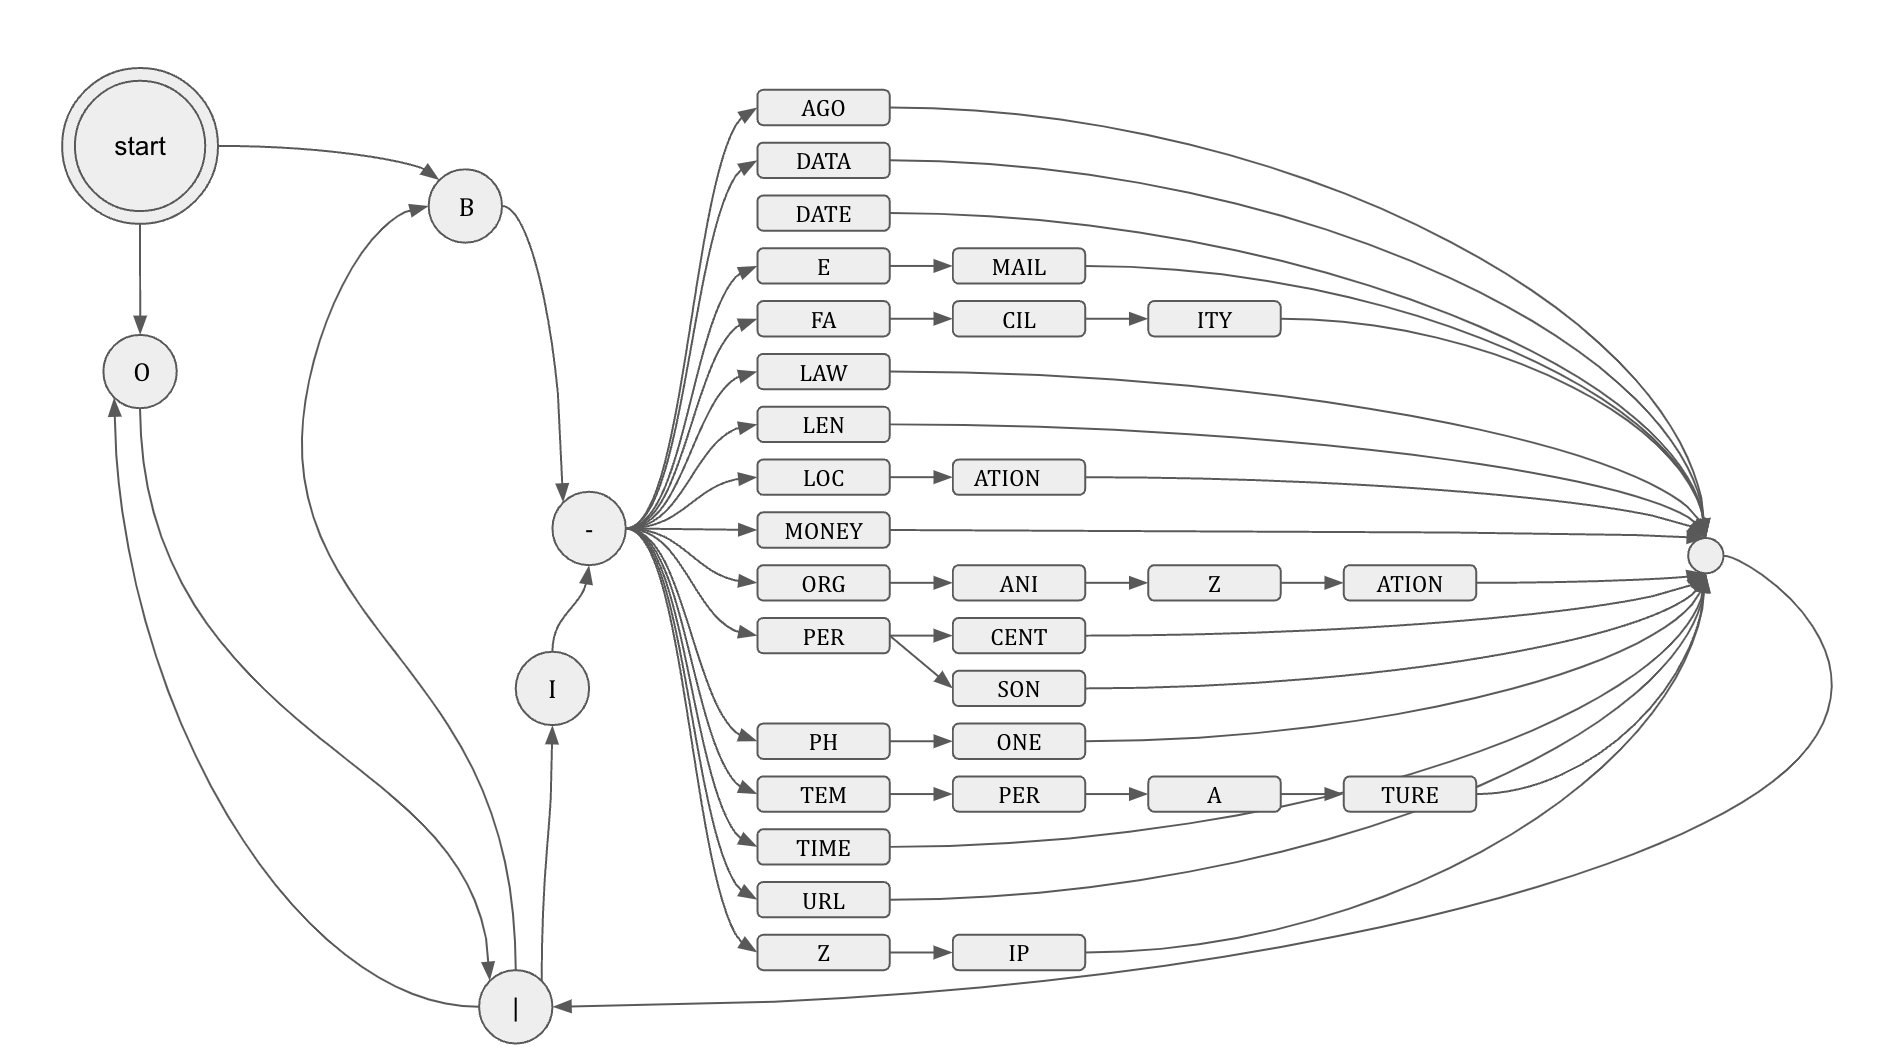

### Prepare Decoder Class
Now that we know how we defined our constrained predicition using the state transition constraint from the image above, let's implement the decoder class!

In [ ]:
class ICLDecoderForNER(object):

    def __init__(
        self,
        tokenizer: AutoTokenizer,
        ner_token_ids: dict,
        special_token_ids: dict,
        verbose: bool = False
    ) -> None:
        """
        In-Context Learning Decoder for NER

        This class wraps LLM tokenizer and update the state according to
        the pre-defined logit rules

        Attributes
        ----------
        tokenizer: AutoTokenizer
            tokenizer of your LLM
        ner_token_ids: Dict[str, str]
            A mapper mapping your class name to tokenized label
        special_token_ids: Dict[str, str]
            A mapper mapping NER special tokens such as B, I, -, O, and the word delimiter token for LLM

        current_class: str
            An attribute storing class name of the current time step
        predictions: List[str]
            Stores the token predictions of each time step
        possible_token_indices: List[int]
            Stores the current next possible state of the NER model
        class_token_idx: int
            Store a temp variable to keep track of the class subword index that the model predicts
        token_step: int
            Stores token output step
        verbose: bool
            Whether to print the verbose text during decoding
        """
        self.tokenizer = tokenizer
        self.ner_token_ids = ner_token_ids
        self.special_token_ids = special_token_ids
        self.verbose = verbose
        self.reset()

    def reset(self) -> None:
        self.reset_current_class()
        self.predictions = []
        self.possible_token_indices = special_token_ids["B"] + special_token_ids["O"]
        self.class_token_idx = 0
        self.token_step = 0

    def print_log(self, msg: str, *args, **kwargs) -> None:
        """Print log message if self.verbose is True"""
        if self.verbose:
            print(msg, *args, **kwargs)

    def reset_current_class(self) -> None:
        self.current_class = None

    def get_logits_prediction(self, logits: torch.Tensor) -> str:
        """Get the prediction from the logits

        we only select the word score that is possible
        for this case, we only select the vocab index
        that is in the `possible_token_indices`
        note that `possible_token_indices` list keeps
        updating over each token decoded
        """

        # get interested vocab logits
        filtered_logits = logits[self.possible_token_indices]
        # select the vocab with higher value of logits
        self.print_log(f"Pruned logits: ")
        self.print_log({k: v for v, k in zip(filtered_logits, tokenizer.convert_ids_to_tokens(self.possible_token_indices))})
        pred_token_id = self.possible_token_indices[filtered_logits.argmax()]
        self.print_log(f"Finish prediction, the most likely word is {tokenizer.convert_ids_to_tokens(pred_token_id)}")
        return pred_token_id

    def is_latest_b(self) -> bool:
        """Return boolean stating whether the previous token is B or not"""


    def autocomplete(self, from_token: str) -> List[int]:
        if from_token == "B":
            # because NER class name for B always starts with B-[CLASS_NAME]
            # note that the next decoding steps will required LLM
            # to fill class name later
            autocompleted_tokens = [
                *self.special_token_ids["B"],
                *special_token_ids["-"]] # [B, -]
            self.print_log(f"Autocompleted token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(autocompleted_tokens))

            # update possible_token_indices
            # B- only able to followed by first word index of NER class token
            # we stored this value in the `ner_token_ids` earlier
            self.print_log(f"Updating next possible token from {self.tokenizer.convert_ids_to_tokens(autocompleted_tokens)}")
            self.possible_token_indices = [
                token_ids[0]
                for token_ids
                in self.ner_token_ids.values()]
            self.print_log(f"Updated possible next token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(self.possible_token_indices))

        elif from_token == "I":
            # because NER class name for I always starts with I-[CLASS_NAME]
            # however, in ALL cases, if we were to reach I token, we MUST already
            # know the [CLASS_NAME] stored in the `current_class` variable
            # we also fills the current class token as well
            autocompleted_tokens = [
                *self.special_token_ids["I"], # I
                *self.special_token_ids["-"], # -
                *self.ner_token_ids[self.current_class], # list of class tokens,
                *self.special_token_ids[WORD_DELIMITER_TOKEN], # delimited token
            ] # [I, -, {current_class}, WORD_DELIMITER_TOKEN]
            self.print_log(f"Autocompleted token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(autocompleted_tokens))

            # the I token was autocompleted as written in `autocomplete_i`
            # so the next possible token was just B, I or O
            self.print_log(f"Updating next possible token from {self.tokenizer.convert_ids_to_tokens(autocompleted_tokens)}")
            self.possible_token_indices = self.special_token_ids["B"] + self.special_token_ids["I"] + self.special_token_ids["O"]
            self.print_log(f"Updated possible next token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(self.possible_token_indices))

        elif from_token == "O":
            # for class O, we can directly skip to WORD_DELIMITER_TOKEN
            # [O, WORD_DELIMITER_TOKEN]
            autocompleted_tokens = [
                *self.special_token_ids["O"],
                *self.special_token_ids[WORD_DELIMITER_TOKEN]]
            self.print_log(f"Autocompleted token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(autocompleted_tokens))

            # the O token can only continued by another O or B
            self.possible_token_indices = self.special_token_ids["B"] + self.special_token_ids["O"]
            self.reset_current_class()

            self.print_log(f"Updated possible next token:")
            self.print_log(self.tokenizer.convert_ids_to_tokens(self.possible_token_indices))
        else:
            autocompleted_tokens = self._autocomplete_class_tokens(from_token)

        return autocompleted_tokens

    def _autocomplete_class_tokens(self, from_token: str) -> List[int]:
        self.print_log(f"Predicting class token from {from_token}")
        # if the from_token (or pred_token at current timestep) is
        # belongs to which class by checking if the predicted token
        # equals to the first token in label subwords
        self.print_log(f"Matching class from class {self.class_token_idx} token index")
        matched_classes = [
            class_name for class_name, class_ids
            in self.ner_token_ids.items()
            if (len(class_ids) > self.class_token_idx) and \
            class_ids[self.class_token_idx] == tokenizer.convert_tokens_to_ids(from_token)
        ]
        self.print_log(f"The token {from_token} can be autofilled with:")
        self.print_log(matched_classes)

        # we check for matched_classes because there's some case where
        # the match could be ambiguous (e.g. PER => PER CENT or PER SON)
        if len(matched_classes) == 1:
            self.print_log("There's one posible autocomplete")
            # if there's one match, then it's the class that
            # is not ambiguous. We can straight autofill this
            # also reset class token index
            if self.class_token_idx == 0:
                # if class has only one token (e.g. DATE, DATA)
                autocompleted_tokens = self.ner_token_ids[matched_classes[0]] + self.special_token_ids[WORD_DELIMITER_TOKEN]
            else:
                # if class has multiple tokens (e.g. PER+CENT, PER+SON, TEM+PER+A+TURE)
                autocompleted_tokens = [self.ner_token_ids[matched_classes[0]][self.class_token_idx]] + self.special_token_ids[WORD_DELIMITER_TOKEN]

            # reset class token index
            self.class_token_idx = 0

            # update possible next tokens
            # if class token can completely autocomplete
            # the next token can only continued by another I, O or B
            self.possible_token_indices = self.special_token_ids["B"] + self.special_token_ids["I"] + self.special_token_ids["O"]

            self.current_class = "".join(matched_classes[0])
            self.print_log(f"Current class: {self.current_class}")

        else:
            # if there's more than one match, it's ambiguous case
            # need LLM to fill the next vocab to predict class name
            # we can't do auto complete here

            # update class token index for llm decoding
            self.print_log("There seems to be multiple matched token")
            self.class_token_idx += 1
            self.print_log("Letting model fill more token")
            self.print_log("Updating next possible token...")
            self.possible_token_indices = [
                self.ner_token_ids[class_name][self.class_token_idx]
                for class_name in matched_classes
            ]
            self.print_log(f"Updated possible next tokens:")
            self.print_log(self.possible_token_indices)

            autocompleted_tokens = tokenizer.convert_tokens_to_ids([from_token])

        self.print_log("Autocompleted tokens:")
        self.print_log(tokenizer.convert_ids_to_tokens(autocompleted_tokens))

        self.print_log("Updated Possible Next Tokens:")
        self.print_log(self.tokenizer.convert_ids_to_tokens(self.possible_token_indices))
        return autocompleted_tokens

    def update_batch(self, batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        batch = batch.copy()
        batch["input_ids"] = torch.concat([
            batch["input_ids"],
            torch.LongTensor([self.predictions]).to(batch["input_ids"].device)
        ], axis=1)
        batch["attention_mask"] = torch.concat([
            batch["attention_mask"],
            torch.ones(size=(1, len(self.predictions))).to(batch["attention_mask"].device)
        ], axis=1)
        return batch

    def get_ner_prediction_length(self) -> int:
        """Return number of NER tokens predicted"""
        return len(self.tokenizer.decode(self.predictions, ignore_special_tokens=True)\
            .strip(WORD_DELIMITER_TOKEN)\
            .split(WORD_DELIMITER_TOKEN))

    def is_end_of_word(self) -> bool:
        """Whether the predictions is end with WORD_DELIMITER_TOKEN"""
        if len(self.predictions) == 0:
            return False
        return self.predictions[-1] == self.special_token_ids[WORD_DELIMITER_TOKEN][0]

    def step(self, logits: torch.Tensor) -> None:
        """update state of the predictions"""
        self.print_log("="*20)
        self.print_log(f"Updating state for the {self.token_step} step")

        # get vocab string and id from logits
        self.print_log(f"Predicting next token...")
        self.print_log(f"Current possible next possible token:")
        self.print_log(self.tokenizer.convert_ids_to_tokens(self.possible_token_indices))
        pred_token_id = self.get_logits_prediction(logits)
        pred_token = self.tokenizer.convert_ids_to_tokens(pred_token_id)

        # Update possible_token_indices and auto-complete the prediction to speed-up inference
        self.print_log(f"Applying auto complete to token {pred_token}")
        pred_token_ids = self.autocomplete(pred_token)
        self.predictions.extend(pred_token_ids)

        # update token step
        self.token_step += 1

## Test Inference on one sample
Now that we've completed going through ICL Decoder, let's try using our decoder to predict a single sample

In [ ]:
# create prompt

idx = 13 # test index
num_example = 2 # number of few-shot samples

words = dataset["test"][idx]["words"] # get word from test set
labels = dataset["test"][idx]["ner"]
prompt = create_prompt(words, examples=sample_examples(dataset["train"], num_example=num_example))
print(prompt)

print()
print("LABEL>")
print(WORD_DELIMITER_TOKEN.join([classes_list[i] for i in labels]))

จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร

ข้อความ:สำหรับ|เจ้าหน้าที่| |ที่|ลง|ปฏิบัติงาน|ได้|ให้|สวม|ชุด|ป้องกัน|โรคระบาด| |ใส่|รองเท้าบูท| |สวม|หมวก
คำตอบ:O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O

ข้อความ:สำนักงาน|คณะกรรมการ|วิจัย|แห่งชาติ| |หรือ| |วช.| |เปิด|โครงการ|อาหารกลางวัน|เพื่อ|สุขภาพ|ของ|เด็กวัยเรียน| |พัฒนา|สูตร|อาหาร|โดย|ใช้|วัตถุดิบ|ใน|ท้องถิ่น| |และ|การปรุง|ที่|ไม่|เค็ม| |ไม่|หวาน|และ|ลด|ไขมัน| |ทำให้|เด็กนักเรียน|ได้รับ|สารอาหาร|ที่|มีประโยชน์|อย่าง|ครบถ้วน|ตาม|หลัก|โภชนาการ|ที่|สมวัย
คำตอบ:B-ORGANIZATION|I-ORGANIZATION|I-ORGANIZATION|I-ORGANIZATION|O|O|O|B-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O

ข้อความ:นาย|ประกอบ|รัตน์| |เดชา|กุล|ทนายความ|ตัวแทน|ของ|นาง|สัง|วาลย์| |กล่าวว่า|ลูกความ|เรียกค่าเสียหาย|เป็น|เงิน|6|ล้าน|บาท|เพราะ|ได้รับ|บาดเจ็บสาหัส|ขา|ซ้าย|หัก|2|ท่อน|แผ่น|หลัง|ถูก|น้ำร้อน|จาก|หม้อน้ำ|รถ|ลวก|ต้อง|รักษา|โดย|การขูด|เอา|เนื้อที่|ตาย|ทิ้ง|แล้ว|เอา|เนื้อ|มา|ปะ|ติด|ใหม่|ใน|ทางการแพทย์|นั้น|ยัง|ต้อ

In [ ]:
decoder = ICLDecoderForNER(tokenizer, ner_token_ids, special_token_ids, verbose=True)

batch = tokenizer([prompt], return_tensors="pt").to(model.device)
model.eval()

# continue until predicted token equals to number of train word
while decoder.get_ner_prediction_length() <= len(words):

    if decoder.get_ner_prediction_length() > 0:
        updated_batch = decoder.update_batch(batch)
        input_length = len(updated_batch["input_ids"][0])
    else:
        updated_batch = batch.copy()
        input_length = len(updated_batch["input_ids"][0])

    print("input>")
    print(tokenizer.decode(updated_batch["input_ids"][0], skip_special_tokens=True))

    with torch.no_grad():
        # forward model
        output = model.generate(
            **updated_batch,
            max_length=input_length+1,  # we only need to predict one additional word anyway
            output_hidden_states=True,
            output_scores=True,
            do_sample=False,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )
        logits = output.scores[0][0].cpu().numpy()

    decoder.step(logits)

    print("")
    print(prompt+tokenizer.decode(decoder.predictions, skip_special_tokens=True))

word_predictions = [
    class_to_idx[i]
    for i in tokenizer.decode(
        decoder.predictions,
        skip_special_tokens=True
    ).strip(WORD_DELIMITER_TOKEN).split(WORD_DELIMITER_TOKEN)
]

input>
จงหาเอนทิตีในข้อความพร้อมระบุว่าเป็นเอนทิตีประเภทอะไร ข้อความ:สําหรับ|เจ้าหน้าที่| |ที่|ลง|ปฏิบัติงาน|ได้|ให้|สวม|ชุด|ป้องกัน|โรคระบาด| |ใส่|รองเท้าบูท| |สวม|หมวก คําตอบ:O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O ข้อความ:สํานักงาน|คณะกรรมการ|วิจัย|แห่งชาติ| |หรือ| |วช.| |เปิด|โครงการ|อาหารกลางวัน|เพื่อ|สุขภาพ|ของ|เด็กวัยเรียน| |พัฒนา|สูตร|อาหาร|โดย|ใช้|วัตถุดิบ|ใน|ท้องถิ่น| |และ|การปรุง|ที่|ไม่|เค็ม| |ไม่|หวาน|และ|ลด|ไขมัน| |ทําให้|เด็กนักเรียน|ได้รับ|สารอาหาร|ที่|มีประโยชน์|อย่าง|ครบถ้วน|ตาม|หลัก|โภชนาการ|ที่|สมวัย คําตอบ:B-ORGANIZATION|I-ORGANIZATION|I-ORGANIZATION|I-ORGANIZATION|O|O|O|B-ORGANIZATION|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O|O ข้อความ:นาย|ประกอบ|รัตน์| |เดชา|กุล|ทนายความ|ตัวแทน|ของ|นาง|สัง|วาลย์| |กล่าวว่า|ลูกความ|เรียกค่าเสียหาย|เป็น|เงิน|6|ล้าน|บาท|เพราะ|ได้รับ|บาดเจ็บสาหัส|ขา|ซ้าย|หัก|2|ท่อน|แผ่น|หลัง|ถูก|น้ําร้อน|จาก|หม้อน้ํา|รถ|ลวก|ต้อง|รักษา|โดย|การขูด|เอา|เนื้อที่|ตาย|ทิ้ง|แล้ว|เอา|เนื้อ|มา|ปะ|ติด|ใหม่|ใน|ทางการแพทย์|น

In [ ]:
benchmark.eval(predictions=[word_predictions], labels=[labels])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.8533333333333334}

## Predict test set
Now that single-example ICL works just like we wanted, let's predict the whole test set!

In [ ]:
# hyperparameter
num_example = 2
decoder = ICLDecoderForNER(tokenizer, ner_token_ids, special_token_ids, verbose=False)

predictions = []

model.eval()
for example in tqdm(dataset["test"], desc="Predicting ICL for NER", total=len(dataset["test"])):
    # reset decoder every prediction
    decoder.reset()

    # generate prompt
    words, labels = example["words"], example["ner"]
    prompt = create_prompt(words, examples=sample_examples(dataset["train"], num_example=num_example))
    # encode prompt
    batch = tokenizer([prompt], return_tensors="pt").to(model.device)

    # continue until predicted token equals to number of train word
    while True:

        if (decoder.get_ner_prediction_length() > len(words)) and decoder.is_end_of_word():
            # stop if predicted enough NER tokens and
            # is currently end of word
            break

        if decoder.get_ner_prediction_length() > 0:
            updated_batch = decoder.update_batch(batch)
            input_length = len(updated_batch["input_ids"][0])
        else:
            updated_batch = batch.copy()
            input_length = len(updated_batch["input_ids"][0])

        with torch.no_grad():
            # forward model
            output = model.generate(
                **updated_batch,
                max_length=input_length+1,  # we only need to predict one additional word anyway
                output_hidden_states=True,
                output_scores=True,
                do_sample=False,
                return_dict_in_generate=True,
                pad_token_id=tokenizer.eos_token_id
            )
            logits = output.scores[0][0].cpu().numpy()

        decoder.step(logits)

    # benchmark class receives object as an index
    word_predictions = [
        class_to_idx[i]
        for i in tokenizer.decode(
            decoder.predictions,
            skip_special_tokens=True
        ).strip(WORD_DELIMITER_TOKEN).split(WORD_DELIMITER_TOKEN)
    ]

    predictions.append(word_predictions)

Predicting ICL for NER:   0%|          | 0/1313 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Evaluate the predictions
To evaluate the predictions, we can use the predefined `benchmark` object that stores `seqeval` evaluator.

In [ ]:
metric = benchmark.eval(
    predictions=predictions,
    labels=[sample["ner"] for sample in dataset["test"]][:len(predictions)]
)
print("\nTest set results:")
metric


Test set results:


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.03225806451612903,
 'recall': 0.014184397163120567,
 'f1': 0.019704433497536946,
 'accuracy': 0.7178147268408551}